In [1]:
import torch 
import torch.nn.functional  as F 
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build tokenzier
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] =0 
itos = {i:s for i,s in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
27


In [6]:
# dataset 
block_size=3 

def build_dataset(words):
    X,Y = [],[]
    
    for w in words:
        context = [0] *block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context =context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y 

import random 
random.seed(42)
random.shuffle(words) 
n1= int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP revisted 
n_embd =10 
n_hidden = 200

g=torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd),generator=g)
W1 = torch.randn((n_embd*block_size,n_hidden),generator=g)
b1 = torch.randn(n_hidden,generator=g)
W2 = torch.randn((n_hidden,vocab_size),generator=g)
b2 = torch.randn(vocab_size,generator=g)

parameters = [C,W1,b1,W2,b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True

11897


In [9]:
max_steps = 200000
batch_size=32 
lossi = [] 

for i in range(max_steps):
    
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g)
    Xb , Yb = Xtr[ix],Ytr[ix]
    
    emb = C[Xb]
    embcat= emb.view(emb.shape[0],-1)
    hpreact= embcat@ W1 +b1 
    h = torch.tanh(hpreact)
    logits= h@ W2 + b2 
    loss = F.cross_entropy(logits,Yb)
    
    for p in parameters:
        p.grad = None 
    loss.backward()
    
    lr = 0.1 if i <100000 else  0.01
    for p in parameters:
        p.data += -lr * p.grad 
        
    if i %10000 == 0 :
        print(f"{i:7d}/{max_steps:7d} : {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000 : 2.8181
  10000/ 200000 : 2.8312
  20000/ 200000 : 2.0579
  30000/ 200000 : 2.0053
  40000/ 200000 : 2.4779
  50000/ 200000 : 2.5303
  60000/ 200000 : 2.3766
  70000/ 200000 : 2.5537
  80000/ 200000 : 1.7431
  90000/ 200000 : 2.7209
 100000/ 200000 : 2.1111
 110000/ 200000 : 2.0441
 120000/ 200000 : 2.3435
 130000/ 200000 : 2.4104
 140000/ 200000 : 2.4881
 150000/ 200000 : 2.1495
 160000/ 200000 : 2.0445
 170000/ 200000 : 2.2460
 180000/ 200000 : 2.2180
 190000/ 200000 : 2.1275


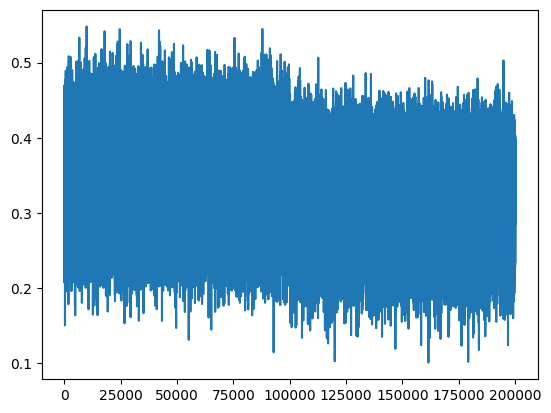

In [10]:
plt.plot(lossi)

In [13]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train' : (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test' : (Xte,Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    h = torch.tanh(embcat@ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())
split_loss('train')
split_loss('val')

train 2.094224691390991
val 2.1442694664001465
